# NYC Taxi Data: Linear Regression Modeling

In this notebook, we perform linear regression modeling on the NYC taxi dataset. We start by building a standard linear regression model, followed by a Lasso regression model. Additionally, we conduct model diagnostics and implement feature selection using backward elimination.

## Libraries and Initial Setup

We begin by importing the necessary libraries, initializing a Spark session, and loading the preprocessed dataset.


In [62]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expm1
from pyspark.sql.functions import col, to_date
from pyspark.sql import DataFrame
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson

In [63]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)  # Enable eager evaluation for interactive querying
    .config("spark.sql.parquet.cacheMetadata", "true")  # Cache metadata for parquet files
    .config("spark.sql.session.timeZone", "Etc/UTC")  # Set the timezone to UTC
    .getOrCreate()  # Create or retrieve the existing Spark session
)

In [64]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).

    :param sdf: Spark DataFrame
    :return: String stating the shape of sdf
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

## Load Data

We load the preprocessed data from a Parquet file into a Spark DataFrame for modeling.

In [65]:
# Load the preprocessed data from a Parquet file
df_train = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development')
shape(df_train)

Shape of the DataFrame: 4393759 rows, 36 columns.


In [75]:
df_train

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins,pickup_hour,pickup_dayofweek,dropoff_hour,dropoff_dayofweek,days_since_2022_11_01,distance_time_interaction,is_airport_trip,is_tourist_trip,pickup_at_airport,dropoff_at_airport,pickup_at_tourist_attraction,dropoff_at_tourist_attraction,is_holiday_season,is_event_day,avg_temp,precipitation
1,2022-11-01 15:09:19,2022-11-01 15:14:39,1.0,0.2623642721597987,1.0,0,161,230,1,5.0,2.5,0.5,9.999999950000001E-9,0.0,0.3,8.3,2.5,0.0,1.8458266920772781,15,3,15,3,0,4.5,0,1,0,0,1,1,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 16:55:56,2022-11-01 17:06:46,2.0,0.7419373494912821,1.0,0,162,100,1,8.0,3.5,0.5,1.2383742339418191,0.0,0.3,14.75,2.5,0.0,2.4709204086583307,16,3,17,3,0,17.6,0,1,0,0,1,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 18:03:50,2022-11-01 18:35:54,1.0,1.5260563056689624,1.0,0,263,48,1,20.0,3.5,0.5,1.163150812930681,0.0,0.3,26.5,2.5,0.0,3.4985257259251368,18,3,18,3,0,64.8,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 18:14:45,2022-11-01 18:34:13,2.0,0.993251776713987,1.0,0,237,230,1,13.0,3.5,0.5,0.009950340754158134,0.0,0.3,17.31,2.5,0.0,3.0187975469735866,18,3,18,3,0,30.599999999999998,0,1,0,0,0,1,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 18:38:02,2022-11-01 19:00:26,1.0,1.3083328223528814,1.0,0,234,50,2,15.5,3.5,0.5,9.999999950000001E-9,0.0,0.3,19.8,2.5,0.0,3.1527360227910064,18,3,19,3,0,48.6,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 19:28:00,2022-11-01 19:44:28,1.0,0.993251776713987,1.0,0,170,68,1,11.5,3.5,0.5,1.599387578600801,0.0,0.3,19.75,2.5,0.0,2.860294303231406,19,3,19,3,0,32.3,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 23:41:47,2022-11-01 23:53:26,1.0,1.098612292001443,1.0,0,152,74,1,10.0,0.5,0.5,1.335001069363919,0.0,0.3,14.1,0.0,0.0,2.5376572159640434,23,3,23,3,0,46.0,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-02 00:22:14,2022-11-02 00:37:21,1.0,1.131402114716907,1.0,0,230,158,2,9.0,3.0,0.5,9.999999950000001E-9,0.0,0.3,12.8,2.5,0.0,2.7798539338516695,0,4,0,4,1,0.0,0,1,0,0,1,0,0,0,4.127134385206382,9.999999950000001E-9
1,2022-11-02 07:08:00,2022-11-02 07:29:05,1.0,1.3083328223528814,1.0,0,107,140,1,14.5,2.5,0.5,0.6931471855599453,0.0,0.3,18.8,2.5,0.0,3.094823176651052,7,4,7,4,1,18.900000000000002,0,0,0,0,0,0,0,0,4.127134385206382,9.999999950000001E-9
1,2022-11-02 08:13:38,2022-11-02 08:41:56,1.0,1.7578579192765116,1.0,0,163,261,1,20.0,2.5,0.5,1.3862943636198906,0.0,0.3,26.3,2.5,0.0,3.3775875163643185,8,4,8,4,1,38.4,0,1,0,0,1,0,0,0,4.127134385206382,9.999999950000001E-9


### Set Up Evaluators

We set up evaluators to assess the performance of our models using metrics such as RMSE, MAE, and R-squared.

In [76]:
# Define evaluators for RMSE, MAE, and R-squared
rmse_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='mae')
r2_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')

### Data Preparation

In [77]:
shape(df_train)

Shape of the DataFrame: 4393759 rows, 36 columns.


In [78]:
df_train.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'trip_duration_mins',
 'pickup_hour',
 'pickup_dayofweek',
 'dropoff_hour',
 'dropoff_dayofweek',
 'days_since_2022_11_01',
 'distance_time_interaction',
 'is_airport_trip',
 'is_tourist_trip',
 'pickup_at_airport',
 'dropoff_at_airport',
 'pickup_at_tourist_attraction',
 'dropoff_at_tourist_attraction',
 'is_holiday_season',
 'is_event_day',
 'avg_temp',
 'precipitation']

### Feature Selection for Linear Model

In the linear model, the following columns were selected for use:

- **VendorID**
- **trip_distance**
- **RatecodeID**
- **PULocationID**
- **DOLocationID**
- **mta_tax**
- **tolls_amount**
- **improvement_surcharge**
- **congestion_surcharge**
- **airport_fee**
- **pickup_hour**
- **pickup_dayofweek**
- **days_since_2022_11_01**
- **dropoff_at_airport**
- **pickup_at_tourist_attraction**
- **dropoff_at_tourist_attraction**
- **is_holiday_season**
- **is_event_day**
- **avg_temp**

1. **Avoidance of Multicollinearity**:
   - **Multicollinearity** occurs when two or more features are highly correlated, which can distort the results of a linear model by making it difficult to isolate the effect of individual predictors.
   - For example, `fare_amount`, `trip_duration_mins`, and `trip_distance` are strongly correlated with each other. Including all of them could lead to unreliable coefficients and inflated standard errors.
   - To address this, highly correlated variables were excluded, providing more granular insights without introducing multicollinearity.

2. **Retaining Key Predictors**:
   - Features like `trip_distance`, `pickup_hour`, and `RatecodeID` were retained as they are critical in predicting the target variable (such as fare or trip duration) and are not strongly correlated with each other.
   - Variables such as `pickup_at_tourist_attraction` and `dropoff_at_airport` were included to capture location-specific effects, especially relevant for tourists, without overlapping with other variables.

3. **Inclusion of Temporal and Contextual Variables**:
   - **Temporal variables** like `pickup_hour`, `pickup_dayofweek`, and `days_since_2022_11_01` are included to account for time-based variations in the data.
   - **Contextual variables** such as `is_holiday_season`, `is_event_day`, and `avg_temp` help capture broader influences on taxi demand and fare variability.

=> By selecting these features, the model is designed to be more interpretable and reliable, minimizing issues related to multicollinearity while capturing the essential factors that influence the target variable. This approach ensures that the model coefficients are meaningful and that the model performs better in predicting outcomes based on the selected variables.

In [96]:
# Define the relevant columns to include in the model
relevant_columns = ['VendorID',
                    'trip_distance',
                    'RatecodeID',
                    'PULocationID',
                    'DOLocationID',
                    'mta_tax',
                    'tolls_amount',
                    'improvement_surcharge',
                    'congestion_surcharge',
                    'airport_fee',
                    'pickup_hour',
                    'pickup_dayofweek',
                    'days_since_2022_11_01',
                    'dropoff_at_airport',
                    'pickup_at_tourist_attraction',
                    'dropoff_at_tourist_attraction',
                    'is_holiday_season',
                    'is_event_day',
                    'avg_temp',
                    ]


# Split the data into training and test sets based on the time frame
train_end_date = '2023-03-31'
test_start_date = '2023-04-01'

train_data = df_train.filter(
    (to_date(col('tpep_pickup_datetime')) >= '2022-11-01') & 
    (to_date(col('tpep_pickup_datetime')) <= train_end_date)
)

test_data = df_train.filter(
    (to_date(col('tpep_pickup_datetime')) >= test_start_date) & 
    (to_date(col('tpep_pickup_datetime')) <= '2023-04-30')
)

In [97]:
train_data = train_data.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')
test_data = test_data.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')

## Feature Assembly and Scaling

We use `VectorAssembler` to combine the relevant columns into a single feature vector and then apply `StandardScaler` to standardize the features.

In [99]:
# Assemble the relevant features into a single feature vector
fare_assembler = VectorAssembler(inputCols=relevant_columns, outputCol='unscaled_features')
fare_train_assembled = fare_assembler.transform(train_data)
fare_test_assembled = fare_assembler.transform(test_data)

In [100]:
# Apply standard scaling to the feature vector
fare_scaler = StandardScaler(inputCol='unscaled_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(fare_train_assembled)
fare_train_scaled = fare_scaler_model.transform(fare_train_assembled).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(fare_test_assembled).select('scaled_features', 'fare_amount')

In [101]:
fare_train_scaled.count()

4392592

## Linear Regression Model

We build a standard linear regression model using the scaled features, train the model on the training set, and evaluate its performance on the test set.

In [102]:
# Train a linear regression model on the scaled features
lr = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount')
lr_model = lr.fit(fare_train_scaled)

24/08/25 02:59:45 WARN Instrumentation: [b80dc7f7] regParam is zero, which might cause numerical instability and overfitting.


In [104]:
# Save the trained modelfor quick retrieval
lr_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/linear_model")

In [105]:
# Evaluate the model on the test set and print the performance metrics
lr_predictions = lr_model.transform(fare_test_scaled)

lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
print(f"Linear Regression on test_data - RMSE: {lr_rmse}, MAE: {lr_mae}, R2: {lr_r2}")

Linear Regression on test_data - RMSE: 7.461147925698806, MAE: 3.8167371871369884, R2: 0.779496636743635


### Residuals Analysis for Linear Regression

We analyze the residuals of the linear regression model by plotting the residuals against the fitted values, plotting the histogram of residuals, and creating a Q-Q plot to check for normality.

In [106]:
# Calculate residuals and convert to Pandas DataFrame for analysis
predictions_and_residuals = lr_predictions.select("prediction", "fare_amount").withColumn("residuals", lr_predictions["fare_amount"] - lr_predictions["prediction"])
predictions_and_residuals_pd = predictions_and_residuals.toPandas()

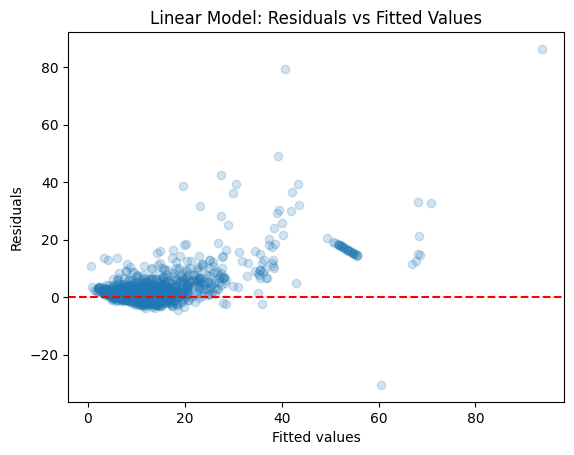

In [107]:
# Plot residuals vs fitted values
plt.scatter(predictions_and_residuals_pd['prediction'], predictions_and_residuals_pd['residuals'], alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Linear Model: Residuals vs Fitted Values')
plt.show()

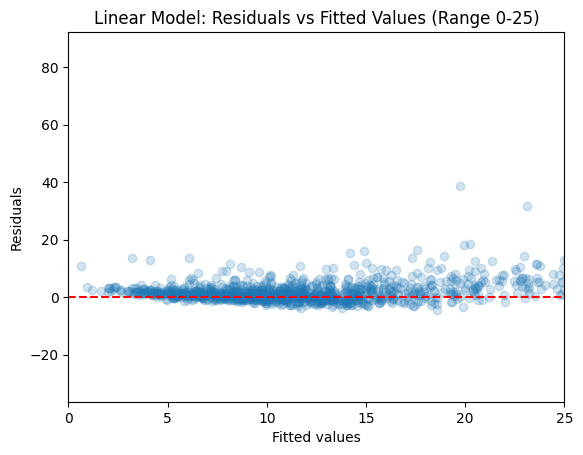

In [113]:
plt.scatter(predictions_and_residuals_pd['prediction'], predictions_and_residuals_pd['residuals'], alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Linear Model: Residuals vs Fitted Values (Range 0-25)')
plt.xlim(0, 25)
plt.show()

1. **Overall Residuals Pattern**:
   - The first plot shows residuals across the full range of fitted values. There is a visible funnel shape, where residuals start small and become more dispersed as the fitted values increase. This pattern indicates heteroscedasticity, where the variance of the residuals increases with the fitted values, which can violate the assumptions of linear regression.

2. **Focused Range (0-25)**:
   - The second plot focuses on the range of fitted values between 0 and 25. Here, the residuals are more tightly clustered around the zero line, indicating that the model fits reasonably well in this lower range.
   - However, there are still some points with relatively large residuals, suggesting potential outliers or non-linear relationships that the model might not be capturing effectively.

3. **Implications**:
   - **Heteroscedasticity**: The increasing spread of residuals at higher fitted values suggests that the model's accuracy decreases as the predicted values increase. This could indicate that the model is not well-suited for predicting higher fare amounts and that a different model or transformation might be needed to better handle this range.
   - **Potential Non-Linearity**: The presence of non-zero residuals across all ranges suggests that the relationship between the predictors and the target variable might not be perfectly linear. This could mean that the model might benefit from including interaction terms, polynomial features, or even switching to a non-linear model.

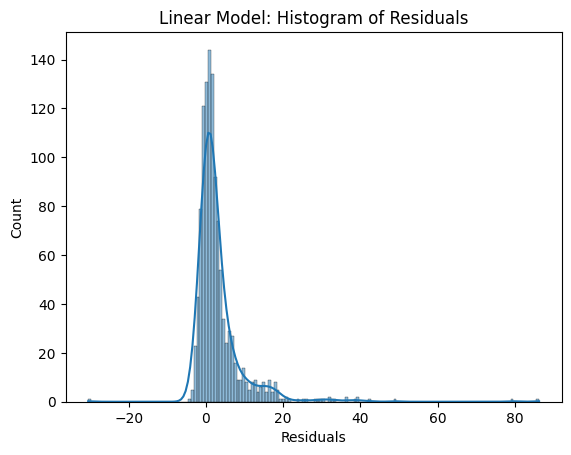

In [114]:
# Plot histogram of residuals
sns.histplot(predictions_and_residuals_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Linear Model: Histogram of Residuals')
plt.show()

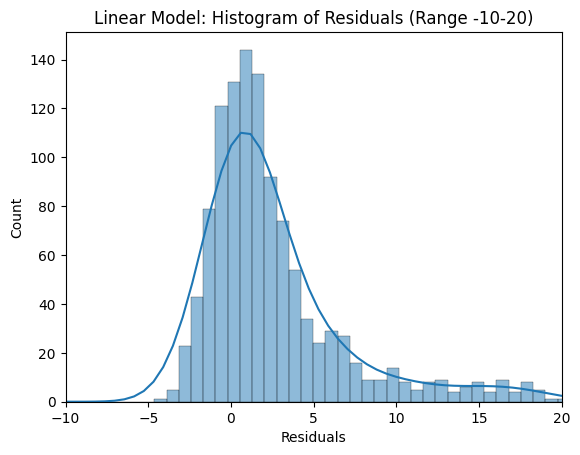

In [119]:
sns.histplot(predictions_and_residuals_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Linear Model: Histogram of Residuals (Range -10-20)')
plt.xlim(-10,20)
plt.show()

1. **Overall Distribution**:
   - The first histogram shows the full range of residuals, with most values clustering near zero but with a noticeable right-skew. This skew indicates that the model tends to underpredict in some cases, resulting in positive residuals.

2. **Focused Range (-10 to 20)**:
   - The second histogram zooms in on a more focused range (-10 to 20), where the bulk of residuals lie. The distribution here appears more normal, but the right skew is still evident.
   - The presence of a peak around zero is expected and desirable, indicating that the model performs well for a large portion of the data. However, the right tail suggests that there are instances where the model significantly underestimates the actual values.

3. **Non-Normality of Residuals**: The right skew in the residuals suggests that the assumptions of normality required for a linear regression model might not be fully met. This could impact the accuracy of confidence intervals and predictions.

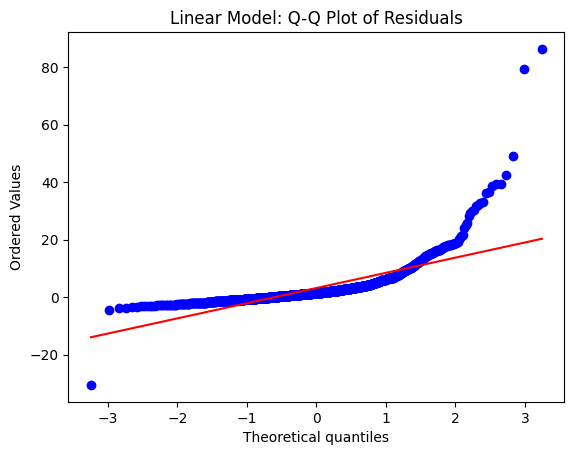

In [120]:
# Q-Q plot of residuals to check normality
probplot(predictions_and_residuals_pd['residuals'], dist="norm", plot=plt)
plt.title('Linear Model: Q-Q Plot of Residuals')
plt.show()

1. **Deviations from Normality**:
   - The Q-Q plot shows that the residuals significantly deviate from the straight line, particularly in the tails. This indicates that the residuals are not normally distributed, with pronounced skewness.
   - The right tail of the plot (positive residuals) deviates upward, showing that the model underpredicts for some higher values, resulting in large positive residuals.

2. **Implications for Model Assumptions**:
   - **Non-Normal Residuals**: The pronounced departure from the normality line suggests that the assumption of normally distributed residuals, a key assumption in linear regression, is violated.
   - **Potential Impact on Inference**: Because the residuals are not normally distributed, this can affect the reliability of confidence intervals and hypothesis tests, potentially leading to inaccurate predictions or conclusions.

### Variance Inflation Factor (VIF)

We calculate the Variance Inflation Factor (VIF) to check for multicollinearity among the predictor variables.

In [121]:
# Load a sample of the training data into a Pandas DataFrame for VIF calculation
pd_df_train = pd.read_parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development').sample(frac=0.1, random_state=1003)
X = pd_df_train[relevant_columns]
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                          feature          VIF
0                           const  6368.358183
1                        VendorID     1.016949
2                   trip_distance     2.071901
3                      RatecodeID     2.278238
4                    PULocationID     1.041921
5                    DOLocationID     1.048077
6                         mta_tax     2.272279
7                    tolls_amount     2.061200
8           improvement_surcharge     1.036838
9            congestion_surcharge     1.503493
10                    airport_fee     2.308571
11                    pickup_hour     1.011550
12               pickup_dayofweek     1.042680
13          days_since_2022_11_01     1.925106
14             dropoff_at_airport     1.532511
15   pickup_at_tourist_attraction     1.060222
16  dropoff_at_tourist_attraction     1.052492
17              is_holiday_season     1.004807
18                   is_event_day     1.007245
19                       avg_temp     1.957254


### Durbin-Watson Statistic

We calculate the Durbin-Watson statistic to test for autocorrelation in the residuals of the linear regression model.

In [122]:
# Calculate the Durbin-Watson statistic for the residuals
dw_statistic = durbin_watson(predictions_and_residuals_pd['residuals'])
print(f'Durbin-Watson statistic: {dw_statistic:.3f}')

Durbin-Watson statistic: 1.645


1. **Variance Inflation Factor (VIF) Analysis**:
   - **VIF**: VIF quantifies the severity of multicollinearity in a regression analysis. A VIF value above 5 indicates a high level of multicollinearity, while values below 5 are generally acceptable.
   - **Key Observations**:
     - All features have VIF values well below the critical threshold of 5, with most values close to 1. This suggests that multicollinearity is not a significant issue in the selected model features.
     - The highest VIF values are seen in `RatecodeID` (2.278) and `airport_fee` (2.309), but these values are still within acceptable limits, indicating that these features do not introduce problematic multicollinearity.

2. **Durbin-Watson Statistic**:
   - **Durbin-Watson**: The Durbin-Watson statistic tests for autocorrelation in the residuals from a statistical regression analysis. Values close to 2 indicate no autocorrelation, while values closer to 0 suggest positive autocorrelation.
   - **Key Observation**:
     - The Durbin-Watson statistic for this model is 1.645, which is close to 2, indicating that there is no significant autocorrelation in the residuals. This suggests that the residuals are independent, a favorable outcome for the linear regression model.

### Coefficients of Linear Regression

We print the coefficients of the trained linear regression model to understand the impact of each feature on the predicted fare amount.

In [125]:
# Print the coefficients of the linear regression model
coefficients = lr_model.coefficients

for feature, coeff in zip(relevant_columns, coefficients):
    print(f"Feature: {feature}, Coefficient: {coeff:.4f}")

Feature: VendorID, Coefficient: -0.0798
Feature: trip_distance, Coefficient: 8.7367
Feature: RatecodeID, Coefficient: 3.4030
Feature: PULocationID, Coefficient: 0.0420
Feature: DOLocationID, Coefficient: 0.0755
Feature: mta_tax, Coefficient: -0.2546
Feature: tolls_amount, Coefficient: 0.9888
Feature: improvement_surcharge, Coefficient: 0.0169
Feature: congestion_surcharge, Coefficient: -0.3170
Feature: airport_fee, Coefficient: 0.6592
Feature: pickup_hour, Coefficient: 0.2017
Feature: pickup_dayofweek, Coefficient: 0.2273
Feature: days_since_2022_11_01, Coefficient: 0.1680
Feature: dropoff_at_airport, Coefficient: 0.2664
Feature: pickup_at_tourist_attraction, Coefficient: 0.1741
Feature: dropoff_at_tourist_attraction, Coefficient: 0.4333
Feature: is_holiday_season, Coefficient: 0.0376
Feature: is_event_day, Coefficient: -0.1796
Feature: avg_temp, Coefficient: -0.0204


- **Dominant Factors**: The most significant positive contributors to fare amount are trip distance, RatecodeID, and tolls, reflecting expected fare components.
- **Negative Effects**: Certain features, like VendorID and mta_tax, show small negative coefficients, which might indicate adjustments or discounts in specific cases.
- **Complex Interactions**: Some coefficients, like the congestion surcharge, suggest complex interactions that might require further exploration to fully understand.

## Lasso Regression Model

We train a Lasso regression model, which includes L1 regularization to penalize the magnitude of the coefficients. This model is trained on the scaled features and evaluated on the test set.

In [126]:
# Train a Lasso regression model with L1 regularization
lasso = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount', elasticNetParam=0.5, regParam=0.1)
lasso_model = lasso.fit(fare_train_scaled)

In [128]:
# Save the Lasso model
lasso_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/lasso_model")

In [129]:
# Evaluate the Lasso model on the test set and print the performance metrics
lasso_test_predictions = lasso_model.transform(fare_test_scaled)

lasso_test_rmse = rmse_evaluator.evaluate(lasso_test_predictions)
lasso_test_mae = mae_evaluator.evaluate(lasso_test_predictions)
lasso_test_r2 = r2_evaluator.evaluate(lasso_test_predictions)
print(f"Lasso Regression on test_data - RMSE: {lasso_test_rmse}, MAE: {lasso_test_mae}, R2: {lasso_test_r2}")

Lasso Regression on test_data - RMSE: 7.580059381413359, MAE: 3.9370426599268646, R2: 0.7724121187142463


### Residuals Analysis for Lasso Regression

Similar to the linear regression model, we analyze the residuals of the Lasso regression model by plotting the residuals against the fitted values, plotting the histogram of residuals, and creating a Q-Q plot.

In [130]:
# Calculate residuals for the Lasso model and convert to Pandas DataFrame for analysis
predictions_and_residuals_lasso = lasso_test_predictions.select("prediction", "fare_amount").withColumn("residuals", lasso_test_predictions["fare_amount"] - lasso_test_predictions["prediction"])
predictions_and_residuals_lasso_pd = predictions_and_residuals.toPandas()

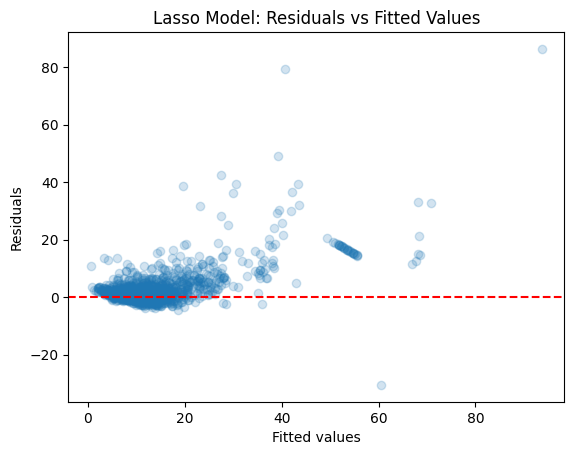

In [131]:
# Plot residuals vs fitted values for the Lasso model
plt.scatter(predictions_and_residuals_lasso_pd['prediction'], predictions_and_residuals_lasso_pd['residuals'], alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Lasso Model: Residuals vs Fitted Values')
plt.show()

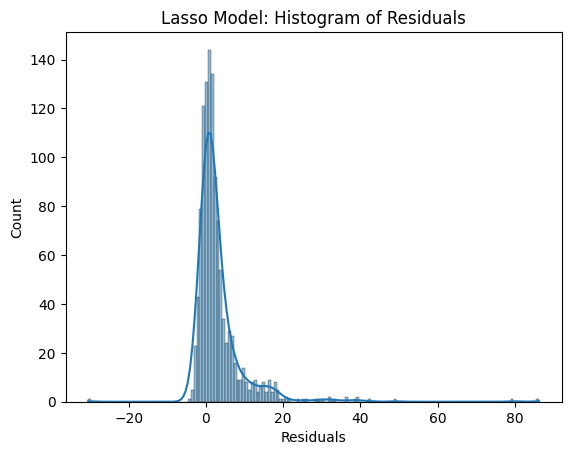

In [135]:
# Plot histogram of residuals for the Lasso model
sns.histplot(predictions_and_residuals_lasso_pd['residuals'], kde=True)
plt.xlabel('Residuals')
plt.title('Lasso Model: Histogram of Residuals')
plt.show()

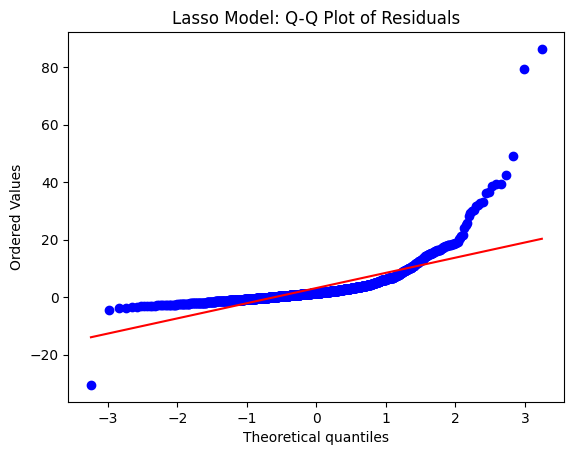

In [134]:
# Q-Q plot of residuals for the Lasso model to check normality
probplot(predictions_and_residuals_lasso_pd['residuals'], dist="norm", plot=plt)
plt.title('Lasso Model: Q-Q Plot of Residuals')
plt.show()

1. **Residuals vs. Fitted Values**:
   - The residuals vs. fitted values plot shows a similar pattern to the linear regression model, with residuals clustering around zero at lower fitted values and spreading out as the fitted values increase. This indicates **heteroscedasticity**, where residuals have increasing variance at higher predicted values. The Lasso model appears to struggle with predicting higher values accurately, leading to larger residuals.

2. **Histogram of Residuals**:
   - The histogram of residuals shows a right-skewed distribution, where most residuals are close to zero, but a significant number are positive, indicating underprediction. The distribution is not perfectly normal, with a notable skew to the right, similar to what was observed in the linear regression model.

3. **Q-Q Plot of Residuals**:
   - The Q-Q plot reveals that the residuals deviate from the normal distribution, particularly in the tails. The right tail, representing large positive residuals, deviates upward, showing that the model underpredicts in certain cases, leading to residuals that are much larger than would be expected under a normal distribution.

- **Heteroscedasticity**: The increasing spread of residuals with larger fitted values suggests that the Lasso model, like the linear model, may not adequately capture relationships at higher values.
- **Non-Normal Residuals**: The right-skew in both the histogram and Q-Q plot indicates that the residuals are not normally distributed, which could affect the reliability of inferences made from the model.
- **Lasso Regularization Impact**: Despite the regularization introduced by the Lasso model, which penalizes large coefficients and can reduce overfitting, the model still exhibits significant issues with heteroscedasticity and non-normal residuals.

### Coefficients of Lasso Regression

We print the coefficients of the trained Lasso regression model to understand the impact of each feature on the predicted fare amount, especially focusing on which features are penalized (coefficients closer to zero).

In [137]:
# Print the coefficients of the Lasso regression model
coefficients = lasso_model.coefficients

for feature, coeff in zip(relevant_columns, coefficients):
    print(f"Feature: {feature}, Coefficient: {coeff:.4f}")

Feature: VendorID, Coefficient: -0.0291
Feature: trip_distance, Coefficient: 8.6511
Feature: RatecodeID, Coefficient: 3.3908
Feature: PULocationID, Coefficient: 0.0000
Feature: DOLocationID, Coefficient: 0.0022
Feature: mta_tax, Coefficient: -0.2276
Feature: tolls_amount, Coefficient: 1.0044
Feature: improvement_surcharge, Coefficient: 0.0000
Feature: congestion_surcharge, Coefficient: -0.2702
Feature: airport_fee, Coefficient: 0.6537
Feature: pickup_hour, Coefficient: 0.1508
Feature: pickup_dayofweek, Coefficient: 0.1678
Feature: days_since_2022_11_01, Coefficient: 0.1342
Feature: dropoff_at_airport, Coefficient: 0.2396
Feature: pickup_at_tourist_attraction, Coefficient: 0.1074
Feature: dropoff_at_tourist_attraction, Coefficient: 0.3563
Feature: is_holiday_season, Coefficient: 0.0000
Feature: is_event_day, Coefficient: -0.1256
Feature: avg_temp, Coefficient: 0.0000


## Feature Selection Using Backward Elimination

We implement a backward elimination procedure to identify the most significant features for predicting fare amounts by iteratively removing the least significant feature based on the magnitude of its coefficient.

In [138]:
def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        data_assembled = assembler.transform(data).select("features", label)
        
        # Train the model
        lr = LinearRegression(featuresCol="features", labelCol=label)
        lr_model = lr.fit(data_assembled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break
    
    print(f"Final set of features: {features_to_keep}")
    return features_to_keep

### Selected Features After Backward Elimination

We apply backward elimination on the training data to determine the final set of features and then re-train and evaluate a linear regression model using these features.

In [139]:
# Apply backward elimination to select the most significant features
selected_features = backward_elimination(data=train_data, features=relevant_columns, label='fare_amount', stop_threshold=1.0)

Training model with 19 features.


24/08/25 03:17:52 WARN Instrumentation: [ed44f8f9] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: PULocationID
Training model with 18 features.


24/08/25 03:18:26 WARN Instrumentation: [6f6006b6] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: DOLocationID
Training model with 17 features.


24/08/25 03:18:56 WARN Instrumentation: [170f1ae9] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: days_since_2022_11_01
Training model with 16 features.


24/08/25 03:19:17 WARN Instrumentation: [501243c3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_hour
Training model with 15 features.


24/08/25 03:19:36 WARN Instrumentation: [0b7dd7bc] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_dayofweek
Training model with 14 features.


24/08/25 03:19:50 WARN Instrumentation: [826b4003] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: VendorID
Training model with 13 features.


24/08/25 03:20:07 WARN Instrumentation: [1a320281] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pickup_at_tourist_attraction
Training model with 12 features.


24/08/25 03:20:23 WARN Instrumentation: [69bb9553] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: congestion_surcharge
Training model with 11 features.


24/08/25 03:20:44 WARN Instrumentation: [55d72767] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: tolls_amount
Training model with 10 features.


24/08/25 03:21:02 WARN Instrumentation: [3ae56ca7] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: avg_temp
Training model with 9 features.


24/08/25 03:21:22 WARN Instrumentation: [45b7dec8] regParam is zero, which might cause numerical instability and overfitting.


Final set of features: ['trip_distance', 'RatecodeID', 'mta_tax', 'improvement_surcharge', 'airport_fee', 'dropoff_at_airport', 'dropoff_at_tourist_attraction', 'is_holiday_season', 'is_event_day']


In [141]:
# Assemble the final set of selected features for training and test sets
final_assembler = VectorAssembler(inputCols=selected_features, outputCol="final_features")
train_final = final_assembler.transform(train_data)
test_final = final_assembler.transform(test_data)

# Scale the selected features
are_scaler = StandardScaler(inputCol='final_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(train_final)
fare_train_scaled = fare_scaler_model.transform(train_final).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(test_final).select('scaled_features', 'fare_amount')

IllegalArgumentException: unscaled_features does not exist. Available: VendorID, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, trip_duration_mins, pickup_hour, pickup_dayofweek, dropoff_hour, dropoff_dayofweek, days_since_2022_11_01, distance_time_interaction, is_airport_trip, is_tourist_trip, pickup_at_airport, dropoff_at_airport, pickup_at_tourist_attraction, dropoff_at_tourist_attraction, is_holiday_season, is_event_day, avg_temp, precipitation, final_features

In [ ]:
# Train a final linear regression model using the selected features
final_lr = LinearRegression(featuresCol='scaled_features', labelCol='fare_amount')
final_model = final_lr.fit(fare_train_scaled)

# Evaluate the final model on the test set and print the performance metrics
test_predictions = final_model.transform(fare_test_scaled)
test_rmse = rmse_evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)
test_r2 = r2_evaluator.evaluate(test_predictions)

print(f"Final Model on Test Data -> RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}")

24/08/21 13:41:35 WARN Instrumentation: [4fb838f3] regParam is zero, which might cause numerical instability and overfitting.


Final Model on Test Data -> RMSE: 8.2017526506102, MAE: 5.359482836236612, R2: 0.7668100995718412


In [ ]:
# Save the final linear regression model
final_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/be_linear_model")

In [ ]:
# Stop the Spark session to release resources
spark.stop()